In [67]:
import requests
from google.transit import gtfs_realtime_pb2
from datetime import datetime

# API kulcsod ide
API_KEY = "55bc10e5-ce8e-4a18-ba6f-fdee71636724"
URL = f"https://go.bkk.hu/api/query/v1/ws/gtfs-rt/full/VehiclePositions.pb?key={API_KEY}"

response = requests.get(URL)
response.raise_for_status()

now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")
filename = f"feed_{timestamp_str}.pb"

with open(f"dynamic_gtfs/{filename}", "wb") as f:
    f.write(response.content)

In [68]:
feed = gtfs_realtime_pb2.FeedMessage()
with open(f"dynamic_gtfs/{filename}", "rb") as f:
    feed.ParseFromString(f.read())

In [69]:
timestamp = feed.header.timestamp
print(timestamp)

1760621500


In [70]:
vehicles = feed.entity
len(vehicles)

1730

In [71]:
vehicles[0]

id: "VehiclePosition-BKK_100"
vehicle {
  trip {
    trip_id: "D0477613515"
    start_date: "20251016"
    schedule_relationship: SCHEDULED
    route_id: "1050"
  }
  position {
    latitude: 47.4988327
    longitude: 19.0428352
    bearing: 254
    speed: 8.2311039
  }
  current_stop_sequence: 20
  current_status: IN_TRANSIT_TO
  timestamp: 1760621487
  stop_id: "F00047"
  vehicle {
    id: "100"
    label: "Apor Vilmos tér"
    license_plate: "AADI603"
  }
}

In [72]:
trip_ids = [vehicle.vehicle.trip.trip_id for vehicle in vehicles if vehicle.vehicle.trip.route_id == "0050"]
trip_ids

['D01668220',
 'D01668273',
 'D01668242',
 'D01668261',
 'D01668238',
 'D01668259',
 'D01668249',
 'D01668234',
 'D01668248',
 '',
 'D01668206',
 'D01668228',
 'D01668244',
 'D01668255',
 'D01668277',
 'D01668251',
 'D01668222',
 'D01668236',
 'D01668224',
 'D01668271',
 'D01668232',
 'D01668279',
 'D01668275']

### Plot 5ös busz

In [73]:
import partridge as ptg

gtfs_path = "budapest_gtfs.zip"
feed = ptg.load_feed(gtfs_path, view=None) 

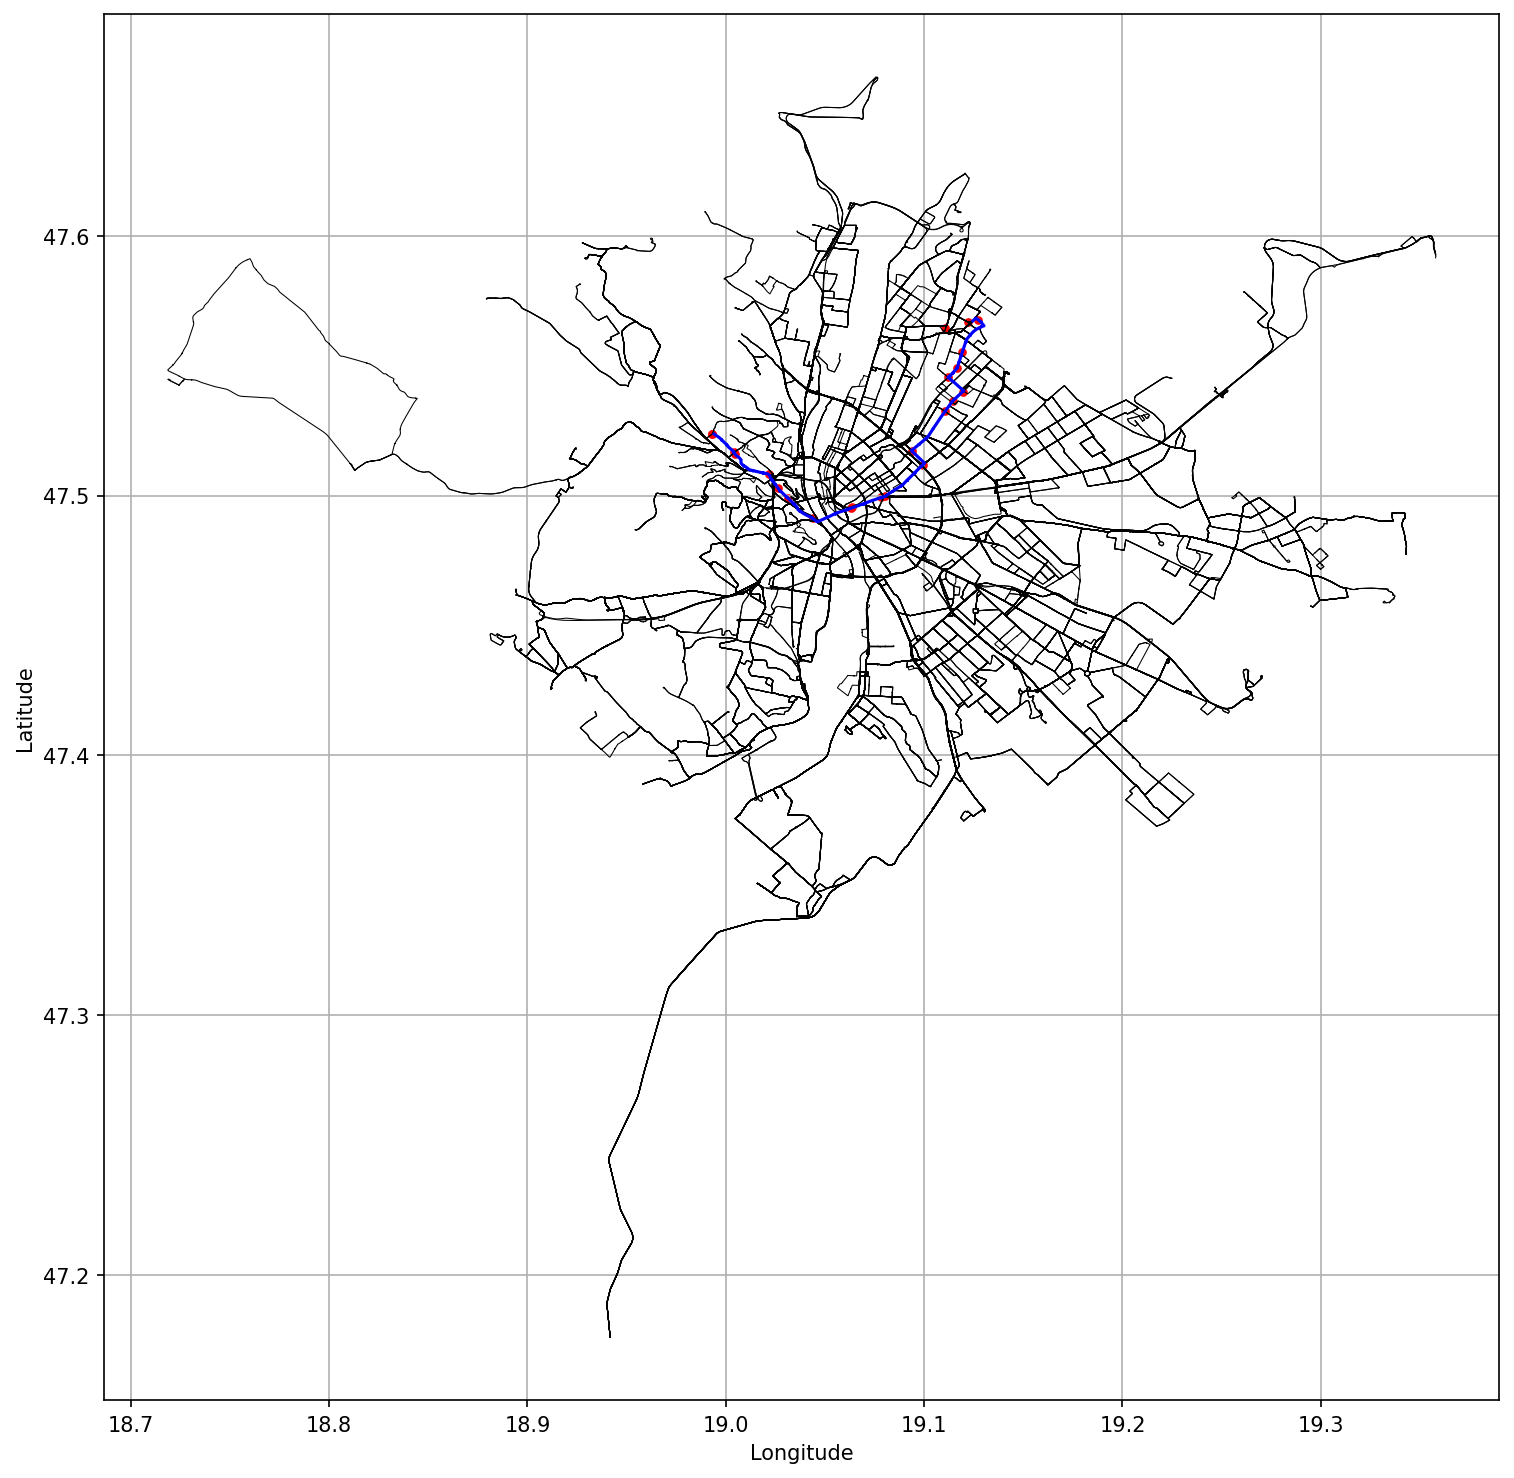

In [74]:
import matplotlib.pyplot as plt

def plot_stops(stops,ax):
    ax.scatter(stops.stop_lon, stops.stop_lat, s=5, c='red', alpha=0.7)

def plot_shapes(shapes,ax,c='black',alpha=1,lw=0.5):
    for shap_id, group in shapes.groupby("shape_id"):
        group = group.sort_values("shape_pt_sequence")
        ax.plot(group["shape_pt_lon"], group["shape_pt_lat"], linewidth=lw,c=c,alpha=alpha)

def plot_shape(shapes, trips, trip_id, ax, c='blue'):

    # Get the shape_id for this trip
    shape_id = trips.loc[trips['trip_id'] == trip_id, 'shape_id'].iloc[0]

    # Filter points for this shape
    shape_points = shapes[shapes['shape_id'] == shape_id].sort_values('shape_pt_sequence')

    # Plot
    ax.plot(shape_points['shape_pt_lon'], shape_points['shape_pt_lat'], c=c)
    


fig, ax = plt.subplots(1,figsize=(12,12),dpi=150)

# plot_stops(feed.stops, ax)
plot_shapes(feed.shapes, ax)
plot_shape(feed.shapes, feed.trips, trip_id=trip_ids[-1] , ax=ax)

for vehicle in vehicles:
    if vehicle.vehicle.trip.route_id == "0050":
        position = vehicle.vehicle.position
        plt.scatter(position.longitude, position.latitude,color='red',marker='o',s=10)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Azok a buszok is látszódnak, amik a garázsban vannak. Ezért kell csekkolni, hogy a feed.vehicle.vehicle.trip-nek van-e trip_id tulajdonsága!!!

In [75]:
for vehicle in vehicles:
    if vehicle.vehicle.trip.route_id == "0050":
        if vehicle.vehicle.trip.trip_id != '':
            print(
                vehicle.vehicle.trip.trip_id, ':',
                vehicle.vehicle.vehicle.label
            )
            vehicleobs = vehicle



D01668220 : Rákospalota, Kossuth utca
D01668273 : Rákospalota, Kossuth utca
D01668242 : Pasaréti tér
D01668261 : Rákospalota, Kossuth utca
D01668238 : Pasaréti tér
D01668259 : Rákospalota, Kossuth utca
D01668249 : Rákospalota, Kossuth utca
D01668234 : Pasaréti tér
D01668248 : Pasaréti tér
D01668206 : Rákospalota, Kossuth utca
D01668228 : Pasaréti tér
D01668244 : Pasaréti tér
D01668255 : Rákospalota, Kossuth utca
D01668277 : Rákospalota, Kossuth utca
D01668251 : Pasaréti tér
D01668222 : Pasaréti tér
D01668236 : Pasaréti tér
D01668224 : Pasaréti tér
D01668271 : Rákospalota, Kossuth utca
D01668232 : Pasaréti tér
D01668279 : Rákospalota, Kossuth utca
D01668275 : Rákospalota, Kossuth utca


In [76]:
vehicleobs.vehicle.trip.trip_id

'D01668275'

In [77]:
stop_times = feed.stop_times
stops = feed.stops

Az adott jármú által éppen teljesítendő trip-hez tartozó menetrend

In [78]:
stop_times[stop_times['trip_id'] == vehicleobs.vehicle.trip.trip_id]

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
1943490,D01668275,048471,54780.0,54780.0,0,NaN,NaN,1,0.0
1943491,D01668275,F00281,54780.0,54780.0,1,NaN,NaN,NaN,393.0
1943492,D01668275,F00283,54840.0,54840.0,2,NaN,NaN,NaN,691.0
1943493,D01668275,F00285,54900.0,54900.0,3,NaN,NaN,NaN,1107.0
1943494,D01668275,F00287,54900.0,54900.0,4,NaN,NaN,NaN,1420.0
1943495,D01668275,F00289,54960.0,54960.0,5,NaN,NaN,NaN,1858.0
1943496,D01668275,F00158,55080.0,55080.0,6,NaN,NaN,NaN,2307.0
1943497,D01668275,F00428,55140.0,55140.0,7,NaN,NaN,NaN,2724.0
1943498,D01668275,F02333,55260.0,55260.0,8,NaN,NaN,NaN,3227.0
1943499,D01668275,F00029,55320.0,55320.0,9,NaN,NaN,NaN,3492.0


Mindig egy trip-hez tartozik a menetrend

In [83]:
from datetime import datetime, timezone

timestamp = vehicleobs.vehicle.timestamp

# UTC
dt_utc = datetime.fromtimestamp(timestamp, tz=timezone.utc)
print("UTC:", dt_utc)

# Local time
dt_local = datetime.fromtimestamp(timestamp)  # defaults to local timezone
print("Local:", dt_local)

total_seconds = dt_local.hour * 3600 + dt_local.minute * 60 + dt_local.second
print(total_seconds) 

UTC: 2025-10-16 13:31:32+00:00
Local: 2025-10-16 15:31:32
55892


In [80]:
def seconds_to_hhmmss(total_seconds):
    h = int(total_seconds // 3600)
    m = int((total_seconds % 3600) // 60)
    s = int(total_seconds % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

In [81]:
print(
    list(stops[stops['stop_id'] == list(stop_times[stop_times['trip_id'] == vehicleobs.vehicle.trip.trip_id]['stop_id'])[0]]['stop_name'])[0],
    seconds_to_hhmmss(list(stop_times[stop_times['trip_id'] == vehicleobs.vehicle.trip.trip_id]['arrival_time'])[0])
)

Pasaréti tér 15:13:00


In [82]:
print(
    list(stops[stops['stop_id'] == list(stop_times[stop_times['trip_id'] == vehicleobs.vehicle.trip.trip_id]['stop_id'])[-1]]['stop_name'])[0],
    seconds_to_hhmmss(list(stop_times[stop_times['trip_id'] == vehicleobs.vehicle.trip.trip_id]['arrival_time'])[-1])
)

Rákospalota, Kossuth utca 16:18:00


Megvan az, hogy hogy kapom meg, hogy hol kéne legyen az adott jármű amit lekérdezek. A trip_id alapján (az ha épp trip-et teljesít a jármű elérhető), le tudom kérdezni, hogy mikor hol kéne megálljon, ugyanakkor az adott jármű szolgáltat időbélyeget is, tehát tudom, hogy amikor küldte, akkor éppen hol kéne legyen, vagy tudom, hogy mekkora késésben van.

Mostmár csak az a kérdés, hogy hogyan számolom ki az end of trip delay-t minden időponthoz, minden járműre.

Nem biztos, hogy a node-ok a megállók kell legyenek. Mi van, hogyha a node-ok a járművek és akkor van köztük él, ha adott szakaszon vannak? Butaság?